# Ususarios de Windows, Linux y MAC

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import joblib
from imblearn.over_sampling import SMOTE


# CARGAR Y EXPLORAR LOS DATOS

In [49]:
df = pd.read_csv('usuarios_win_mac_lin.csv')
print("Datos del data set")
display(df.head())
print("\nDescripcion del data set")
display(df.describe())
print("\nTipos de datos:")
print(df.dtypes)

Datos del data set


,duracion,paginas,acciones,valor,clase
0,7.0,2,4,8,2
1,21.0,2,6,6,2
2,57.0,2,4,4,2
3,101.0,3,6,12,2
4,109.0,2,6,12,2



Descripcion del data set


,duracion,paginas,acciones,valor,clase
count,170.000000,170.000000,170.000000,170.000000,170.000000
mean,111.075729,2.041176,8.723529,32.676471,0.752941
std,202.453200,1.500911,9.136054,44.751993,0.841327
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,11.000000,1.000000,3.000000,8.000000,0.000000
50%,13.000000,2.000000,6.000000,20.000000,0.000000
75%,108.000000,2.000000,10.000000,36.000000,2.000000
max,898.000000,9.000000,63.000000,378.000000,2.000000



Tipos de datos:
duracion    float64
paginas       int64
acciones      int64
valor         int64
clase         int64
dtype: object


# Revisar la variable objetivo

In [53]:
print(df['clase'].value_counts())

clase
0    86
2    44
1    40
Name: count, dtype: int64


# Comprobar y mapear etiquetas

In [55]:
print(df['clase'].unique())

# Si conocés el mapeo, por ejemplo:
mapping = {0: 'mac', 1: 'linux', 2: 'windows'}
df['os_name'] = df['clase'].map(mapping)   # opcional, solo para reporte


[2 1 0]


# Limpiar datos

In [57]:
print(df.isnull().sum())  # Ver nulos

for col in ['duracion','paginas','acciones','valor']: #rellenar nulos numéricos con la mediana
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)


duracion    0
paginas     0
acciones    0
valor       0
clase       0
os_name     0
dtype: int64


# Definir modelos a probar

In [73]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Entrenar y evaluar cada modelo

In [75]:
results = {}
for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Entrenar modelo
    if name == 'Random Forest':
        # Random Forest no necesita escalado
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        # SVM y Logistic Regression se benefician del escalado
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Precisión: {accuracy:.4f}")
    
    # Validación cruzada
    if name == 'Random Forest':
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    else:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    print(f"Validación cruzada - Media: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Guardar resultados
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }


--- Random Forest ---
Precisión: 0.7647
Validación cruzada - Media: 0.6759 (+/- 0.1681)

--- SVM ---
Precisión: 0.6765
Validación cruzada - Media: 0.5074 (+/- 0.0983)

--- Logistic Regression ---
Precisión: 0.7059
Validación cruzada - Media: 0.6394 (+/- 0.0901)


# MEJOR MODELO con mejor precisión es Random Forest

In [77]:
# Encontrar el mejor modelo
mejor_modelo = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_accuracy = results[mejor_modelo]['accuracy']

print(f"Mejor modelo: {mejor_modelo} con precisión: {best_accuracy:.4f}")

Mejor modelo: Random Forest con precisión: 0.7647


# Reentrenar el mejor modelo

In [89]:
best_model = models[best_model_name]
if best_model_name == 'Random Forest':
    best_model.fit(X_train, y_train)
    best_predictions = best_model.predict(X_test)
else:
    best_model.fit(X_train_scaled, y_train)
    best_predictions = best_model.predict(X_test_scaled)

# Matriz de confusión
print(f"\nMatriz de Confusión:")
cm = confusion_matrix(y_test, best_predictions)
print(cm)

print("# Clase 0 (Linux),\n# Clase 1 (Mac), \n# Clase 2 (Windows)")


Matriz de Confusión:
[[12  0  5]
 [ 3  5  0]
 [ 0  0  9]]
# Clase 0 (Linux),
# Clase 1 (Mac), 
# Clase 2 (Windows)


# Reporte de clasificación

In [91]:
print(f"\nReporte de Clasificación:")
if y.dtype == 'object':
    target_names = label_encoder.classes_
else:
    target_names = None

print(classification_report(y_test, best_predictions, target_names=target_names))



Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        17
           1       1.00      0.62      0.77         8
           2       0.64      1.00      0.78         9

    accuracy                           0.76        34
   macro avg       0.81      0.78      0.77        34
weighted avg       0.81      0.76      0.76        34



# Visualizar matriz de confusión

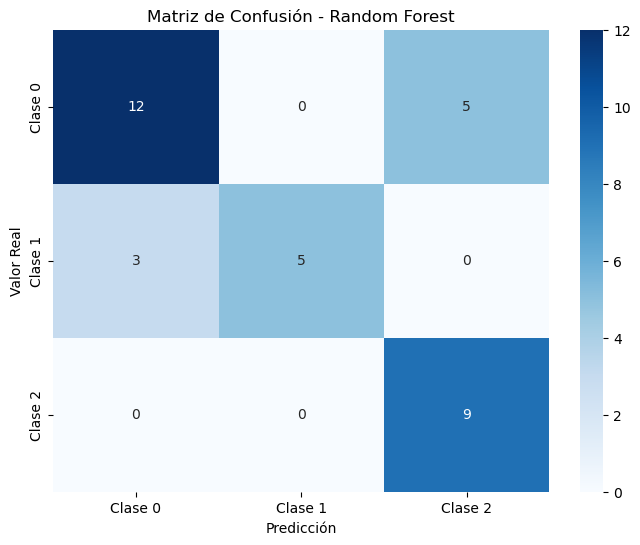

In [93]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names if target_names is not None else ['Clase 0', 'Clase 1', 'Clase 2'],
            yticklabels=target_names if target_names is not None else ['Clase 0', 'Clase 1', 'Clase 2'])
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()